# STEP34 sin関数の高階微分

## これまでの流れ

- STEP27:テイラー展開の微分
- STEP28:ローゼンブロック関数を勾配降下法を理解する
- STEP29:ニュートン法を用いた最適化, 勾配法は遅いのでニュートン法による収束高速化を目指す
- STEP30:Back propagation の実装を見直して2階微分, 3階微分など高階微分に対応できるようにする(準備)
- STEP31:Back propagation の実装を見直して2階微分, 3階微分など高階微分に対応できるようにする(理論)
- STEP32:Back propagation の実装を見直して2階微分, 3階微分など高階微分に対応できるようにする(実装)
- STEP33:ニュートン法は2階微分を使うので、STEP30〜STEP32までの成果を使って自動に最適化計算を行ってみる
- STEP34:sin関数の高階微分, 新しい関数としてsin関数/cos関数を実装する

## 事前準備

### dezero パッケージ読み込み

In [3]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
#import dezero.functions as F

## 34.1 sin関数の実装

### `dezero/functions.py`へsin関数を実装する

- $y=\sin \left( x\right)$　のとき、その微分は $\frac{\partial y}{\partial x} = \cos \left(x\right)$ となることを利用
- 下記コメントのようにfoward計算は`ndarray`型, いっぽうbackwardは`Varaiable`型のため、`cos`関数の実装が別途必要になる

```python
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)       # yはndarray
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x)    # gxはVariable
        return gx


def sin(x):
    return Sin()(x)
```

### 補足: Sin関数の引数にどのように値が渡ってくるか復習


#### forward

```python
class Function:
    def __call__(self, *inputs):
        # 入力値はVariable型
        inputs = [as_variable(x) for x in inputs]

        # fowardにわたす前にndarray型にいったん変換
        xs = [x.data for x in inputs]
        
        # ndarrayタイプのxsがforwardの引数として与えられる
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        #出力はVariable型に変換
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            # 関数の入力をVariable型でインスタンス変数として保存
            self.inputs = inputs
            # 関数の出力をVariable型でインスタンス変数として保存
            self.outputs = [weakref.ref(output) for output in outputs]
~~~~ (省略) ~~~~
```

#### backward

```python
class Variable:

~~~~ (省略) ~~~~
    
    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None:
            self.grad = Variable(np.ones_like(self.data))

~~~~ (省略) ~~~~

        while funcs:
            # 関数名取得
            f = funcs.pop()
            # 関数の出力を取得する。上記のforwardのとき関数の出力をVariable型として保存していることに注意
            gys = [output().grad for output in f.outputs]  # output is weakref

            with using_config('enable_backprop', create_graph):
                # 微分値の計算.Variable型の値を引数として与えている
                gxs = f.backward(*gys)
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)
            
~~~~ (省略) ~~~~
```

## 34.2 cos関数の実装

### `dezero/functions.py`へcos関数を実装する

$y=\cos \left( x\right)$　のとき、その微分は $\frac{\partial y}{\partial x} = -\sin \left(x\right)$ となることを利用

```python
class Cos(Function):
    def forward(self, x):
        y = np.cos(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * -sin(x)
        return gx


def cos(x):
    return Cos()(x)
```

## 34.3 sin関数の高階微分

In [2]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [5]:
x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(f"{i+1} order differential: {x.grad}")

1 order differential: variable(-0.8414709848078965)
2 order differential: variable(-0.5403023058681398)
3 order differential: variable(0.8414709848078965)


## 34.3 sin関数の高階微分

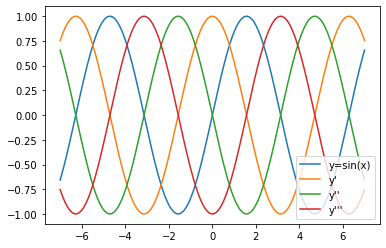

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

# 入力値: -7から7までの200分割する
x = Variable(np.linspace(-7, 7, 200))

# 対象とする関数を定義
y = F.sin(x)

# 1階微分
y.backward(create_graph=True)

# yの元のデータを保存
logs = [y.data.flatten()]

#print(y.data)
#print(logs)

for i in range(3):
    # N回目の微分値を保存 (N=1, 2, 3)
    logs.append(x.grad.data.flatten())
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]

for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()